In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pylsl import StreamInlet, resolve_byprop
import time
from scipy.signal import welch
from IPython.display import clear_output
import random
from IPython.display import clear_output


# Parameters
FS = 256  # EEG sampling rate (update based on device)
chunk_length = 12
LSL_SCAN_TIMEOUT = 5
window_size = FS*2  # 2-second window
step_size = FS    # 1-second step

THETA_BAND = (4, 7)
ALPHA_BAND = (8, 13)
BETA_BAND = (14, 30)
GAMMA_BAND = (31, 50)
SIXTY_BAND = (55,65)
# Function to compute band power
def compute_band_power(data, fs, band):
    freqs, psd = welch(data, fs, nperseg=fs)
    band_power = np.trapz(psd[(freqs >= band[0]) & (freqs <= band[1])])
    return band_power

# Resolve EEG stream
print("Looking for an EEG stream...")
streams = resolve_byprop('type', 'EEG', timeout=LSL_SCAN_TIMEOUT)
if not streams:
    raise RuntimeError("EEG Stream not found.")

print("Started acquiring data.")
inlet = StreamInlet(streams[0], max_chunklen=chunk_length)
info = inlet.info()
Nchan = info.channel_count()
ch_names = ['TP9', 'AF7', 'AF8', 'TP10', 'AUX'][:Nchan]



# Function to compute band power
def compute_band_power(data, fs, band):
    freqs, psd = welch(data, fs, nperseg=fs)
    band_power = np.trapz(psd[(freqs >= band[0]) & (freqs <= band[1])])
    return band_power

# Resolve EEG stream
print("Looking for an EEG stream...")
streams = resolve_byprop('type', 'EEG', timeout=LSL_SCAN_TIMEOUT)
if not streams:
    raise RuntimeError("EEG Stream not found.")

print("Started acquiring data.")
inlet = StreamInlet(streams[0], max_chunklen=chunk_length)
info = inlet.info()
Nchan = info.channel_count()
ch_names = ['TP9', 'AF7', 'AF8', 'TP10', 'AUX'][:Nchan]

def collect_data(label, recording_time = 30):
    print(f"Please {label} for {recording_time} seconds...")
    start_time = time.time()
    all_data = []
    all_timestamps = []

    while time.time() - start_time < recording_time:
        data, timestamps = inlet.pull_chunk(timeout=0.1, max_samples=chunk_length)
        if timestamps:
            all_data.extend(data)
            all_timestamps.extend(timestamps)
    
    all_data = np.array(all_data).T
    return all_data, np.array(all_timestamps)

def process_data(all_data, all_timestamps):
    theta_levels, alpha_levels, beta_levels, gamma_levels, sixty_levels = [], [], [], [], []
    
    for start in range(0, all_data.shape[1] - window_size, step_size):
        window_data = all_data[:, start:start + window_size]
        theta_power = np.mean([compute_band_power(ch_data, FS, THETA_BAND) for ch_data in window_data])
        alpha_power = np.mean([compute_band_power(ch_data, FS, ALPHA_BAND) for ch_data in window_data])
        beta_power = np.mean([compute_band_power(ch_data, FS, BETA_BAND) for ch_data in window_data])
        gamma_power = np.mean([compute_band_power(ch_data, FS, GAMMA_BAND) for ch_data in window_data])
        sixty_power = np.mean([compute_band_power(ch_data, FS, SIXTY_BAND) for ch_data in window_data])
        
        theta_levels.append(theta_power)
        alpha_levels.append(alpha_power)
        beta_levels.append(beta_power)
        gamma_levels.append(gamma_power)
        sixty_levels.append(sixty_power)
    
    return theta_levels, alpha_levels, beta_levels, gamma_levels, sixty_levels


def compute_focus_index(theta_levels, alpha_levels, beta_levels):
    """
    Computes the focus index based on EEG frequency band power levels.

    Focus Index = beta power / (alpha power + theta power)

    Parameters:
    - theta_levels: List of theta band power values
    - alpha_levels: List of alpha band power values
    - beta_levels: List of beta band power values

    Returns:
    - focus_index: List of computed focus index values
    """
    theta_levels = np.array(theta_levels)
    alpha_levels = np.array(alpha_levels)
    beta_levels = np.array(beta_levels)

    # Avoid division by zero by adding a small epsilon
    epsilon = 1e-6
    focus_index = beta_levels / (alpha_levels + theta_levels + epsilon)

    return focus_index.tolist()


# focused_data, focused_timestamps = collect_data("focus")
# focused_theta, focused_alpha, focused_beta, focused_gamma, focused_sixty = process_data(focused_data, focused_timestamps)

# calm_data, calm_timestamps = collect_data("relax and be calm")
# calm_theta, calm_alpha, calm_beta, calm_gamma, calm_sixty = process_data(calm_data, calm_timestamps)

threshold_gamma = 8#(np.mean(calm_gamma) + np.mean(focused_gamma))/2 
sixty_threshold = 250#(np.mean(calm_sixty) + np.mean(focused_sixty))/2 


# Initialize the plot
timestamps = []
focus_levels = []
target_focus_levels = []
start_time = time.time()
focus_or_not = True
while True:
    focus_or_not = not focus_or_not
    for iteration in range(15):
        clear_output(wait=True)
        if focus_or_not:
            print("Try and focus")
            target_focus = 14
        else:
            print("Try and relax")
            target_focus = 5
        current_time = time.time() - start_time
        # Simulate data collection
        new_data, new_timestamps = collect_data("test", 2)
        theta_levels, alpha_levels, beta_levels, gamma_levels, sixty_levels = process_data(new_data, new_timestamps)
        focus_level = np.mean(gamma_levels)
        
        # if (target_focus == 14 and focus_level > threshold_gamma) or (target_focus == 5 and focus_level < threshold_gamma):
        #     print("Success")
        # else:
        #     print("Fail")
        #     print(focus_level)

        if(focus_level > threshold_gamma * 2):
            shared_var = 2
        elif (focus_level > threshold_gamma):
            shared_var = 1
        else:
            shared_var = 0
        print(shared_var)
        # Update plot data
        timestamps.append(current_time)
        focus_levels.append(focus_level)
        target_focus_levels.append(target_focus)
    
        # Clear and redraw plot
        
        plt.figure(figsize=(8, 4))
        plt.plot(timestamps, focus_levels, label="Focus Level")
        plt.plot(timestamps, target_focus_levels, label="Target Focus Level", linestyle='dashed')
        plt.xlabel("Time (s)")
        plt.ylabel("Focus Level")
        plt.legend()
        plt.show()
        time.sleep(1)


Looking for an EEG stream...


RuntimeError: EEG Stream not found.

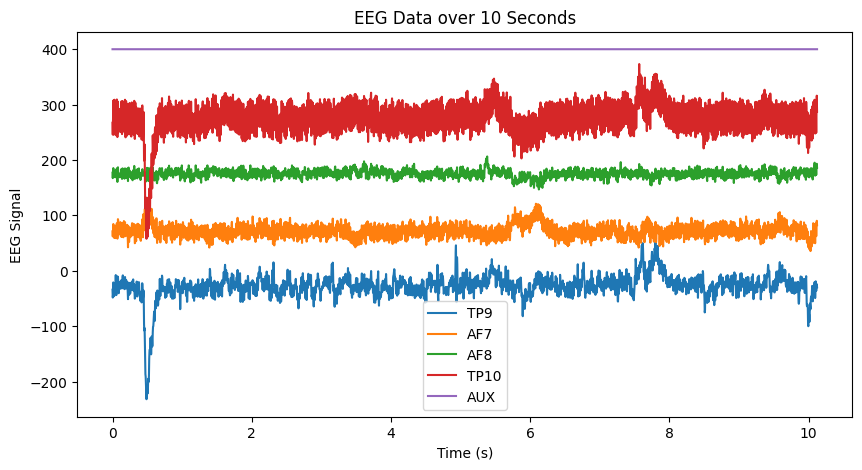

KeyboardInterrupt: 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pylsl import StreamInlet, resolve_byprop
import time
from scipy.signal import welch
from IPython.display import clear_output

# Parameters
FS = 256  # EEG sampling rate (update based on device)
chunk_length = 12
LSL_SCAN_TIMEOUT = 5
recording_time = 10  # seconds
window_size = FS * 2  # 2-second window
step_size = FS  # 1-second step

# Frequency bands
THETA_BAND = (4, 7)
ALPHA_BAND = (8, 13)
BETA_BAND = (14, 30)
GAMMA_BAND = (31, 100)

# Function to compute band power
def compute_band_power(data, fs, band):
    freqs, psd = welch(data, fs, nperseg=fs)
    band_power = np.trapz(psd[(freqs >= band[0]) & (freqs <= band[1])])
    return band_power

# Resolve EEG stream
print("Looking for an EEG stream...")
streams = resolve_byprop('type', 'EEG', timeout=LSL_SCAN_TIMEOUT)
if not streams:
    raise RuntimeError("EEG Stream not found.")

print("Started acquiring data.")
inlet = StreamInlet(streams[0], max_chunklen=chunk_length)
info = inlet.info()
Nchan = info.channel_count()
ch_names = ['TP9', 'AF7', 'AF8', 'TP10', 'AUX'][:Nchan]

# Start real-time wave measurement
while True:
    start_time = time.time()
    all_data = []
    all_timestamps = []

    print("Collecting data for 10 seconds...")
    while time.time() - start_time < recording_time:
        data, timestamps = inlet.pull_chunk(timeout=0.1, max_samples=chunk_length)
        if timestamps:
            all_data.extend(data)
            all_timestamps.extend(timestamps)
    
    all_data = np.array(all_data).T
    all_timestamps = np.array(all_timestamps)
    
    # Plot results
    clear_output(wait=True)
    plt.figure(figsize=(10, 5))

    # EEG raw data plot
    for i in range(Nchan):
        plt.plot(all_timestamps - all_timestamps[0], all_data[i] + i * 100, label=ch_names[i])
    
    plt.xlabel("Time (s)")
    plt.ylabel("EEG Signal")
    plt.title("EEG Data over 10 Seconds")
    plt.legend()
    
    plt.show()


In [14]:
import nest_asyncio
import uvicorn
import threading
from fastapi import FastAPI
import asyncio

# Apply nest_asyncio to allow running FastAPI inside Jupyter
nest_asyncio.apply()

app = FastAPI()

# Global variable to be updated
shared_var = 0

# Async function to simulate real-time updates
async def update_var():
    global shared_var
    while True:
        await asyncio.sleep(1)  # Update every second
        #shared_var += 1

# FastAPI endpoint to return the latest value
@app.get("/latest_value")
async def get_latest_value():
    return {"shared_var": shared_var}

# Start real-time updates in the background
@app.on_event("startup")
async def startup():
    asyncio.create_task(update_var())

# Function to run FastAPI in a separate thread
def run_server():
    uvicorn.run(app, host="127.0.0.1", port=8000)

# Run the server in a separate thread so it doesn't block Jupyter
server_thread = threading.Thread(target=run_server, daemon=True)
server_thread.start()


/var/folders/lg/73zgfwxj6b71jf2dzdpn31s00000gn/T/ipykernel_97343/663312152.py:28: DeprecationWarning: 
        on_event is deprecated, use lifespan event handlers instead.

        Read more about it in the
        [FastAPI docs for Lifespan Events](https://fastapi.tiangolo.com/advanced/events/).
        
  @app.on_event("startup")
INFO:     Started server process [97343]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     4.16.84.182:0 - "GET /latest_value HTTP/1.1" 200 OK


In [4]:
import psutil
import os

def kill_uvicorn():
    current_pid = os.getpid()  # Get Jupyter Notebook's PID
    for proc in psutil.process_iter(attrs=['pid', 'name', 'cmdline']):
        try:
            cmdline = proc.info["cmdline"]
            if cmdline and isinstance(cmdline, list):  # Ensure it's a valid list
                cmdline_str = " ".join(cmdline)
                if "uvicorn" in cmdline_str:
                    if proc.info["pid"] != current_pid:  # Avoid killing Jupyter itself
                        print(f"Killing Uvicorn process: {proc.info['pid']}")
                        proc.kill()
        except (psutil.NoSuchProcess, psutil.AccessDenied, psutil.ZombieProcess):
            pass

kill_uvicorn()
